### In this homework assigment, you are required to apply the neural fitted Q-iteration algorithm to a pre-collected dataset for batch (offline) policy optimisation. Please follow the instructions detailed below.

Step 1: Generate an offline dataset. Consider the CartPole example. We will use a sub-optimal policy for data generation. Specifically, consider the following deterministic policy $\pi_b$ that returns 0 (left) if the pole angle is negative and 1 otherwise. To allow exploration, we set the behavior policy to be a mixture of $\pi_b$ and a uniform random policy. Specifically, the agent will follow the uniform random policy or $\pi_b$ with equal probability. We simulate 100 episodes under this policy. This yields the offline dataset.

Step 2: Fitted Q-iteration. We will apply the neural fitted Q-iteration (FQI) algorithm to this offline data to compute an optimal policy with three different choices of $\gamma$, corresponding to 0.95, 0.99 and 1. Please refer to Page 43 of Lecture 5 for the pseudocode of FQI in batch settings. We repeat the Q-iteration 20 times, e.g., apply supervised learning algorithms 20 times to learn the optimal Q-function. The initial Q-estimator can be set to a zero function. Each iteration yields a Q-estimator, based on which we can derive an estimated optimal policy. In total, we obtain 20 $\times$ 3 (3 choices of $\gamma$) different policies.

* To combine FQI with neural networks, we consider using the [MLPregressor](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html) function. We can use the default neural network architecture (no need to specify no. of layers or no. of hidden nodes per layer). We may set the maximum number of iterations to 500.

* In this example, we only have two actions (either pushing the cart to the left or to the right). As such, it would be better to use the second type of value function approximators on Page 11 of Lecture 5 (e.g., for each action, use a separate model for the value). The last type of approximators would be preferred in settings where we have a large action space.

* The TD target depends on whether the current state is a terminal state or not. For a nonterminal state, the TD target is constructed as in the lecture slide. For a terminal state, the TD target is equal to the immediate reward.

Step 3: Policy evaluation. For each of the computed 60 policies, we use the Monte Carlo method to evaluate the expected return under this policy, by generating 1000 episodes. Finally, plot all the returns in a single figure and comment on the results.

First, let us review the three types of value function approximators

<img  src=./graphs/app3.png  width=750>

Second, let us review the fitted Q-teration algorithm for batch policy learning

<img  src=./graphs/FQI.png  width=750>

The following code implements Step 1 of the assignment. 

In [1]:
import gym  
from sklearn.neural_network import MLPRegressor
import numpy as np

env = gym.make("CartPole-v1")  

def action(angle, epsilon=0):
    if np.random.binomial(1, epsilon) == 1:
        return np.random.choice([0,1])
    else:
        if angle < 0:
            return 0
        else:
            return 1
        
episodes = 100
sar = []
for i in range(episodes):
    obs = env.reset()
    obs = obs[0]
    done = False
    while not done:
        a = action(obs[2], epsilon=0.5)
        obs, r, done, info, sth = env.step(a)
        sar.append([obs, a, r, done])

The following code implements Step 3 of the assignment. Specifically, it implements the Monte Carlo method for policy evaluation.

In [2]:
def policy(obs, regr0, regr1):
    q0 = regr0.predict(np.expand_dims(obs, 0))
    q1 = regr1.predict(np.expand_dims(obs, 0))
    if q0 > q1:
        return 0
    else:
        return 1

def reward(regr0, regr1, episodes=1000):
    rewards = 0
    for i in range(episodes):
        obs = env.reset()
        obs = obs[0]
        done = False
        while not done:
            a = policy(obs, regr0, regr1)
            obs, r, done, info, sth = env.step(a)
            rewards += r
    rewards = rewards / episodes
    return rewards

Finally, we implement the FQI algorithm. As given in the instruction, we will use `MLPRegressor` to solve the supervised learning problem. The input X and y correspond to the $n\times p$ feature matrix and $n$-dimensional response vector, respectively. The `fit` method is used to fit the model and the `predict` method is used to predict the mean outcome conditional on the features.

In [3]:
## Intialize Q-function to be zero and construct target
X = np.zeros((len(sar), len(obs)+1))
y = np.zeros(len(sar))
for i in range(len(sar)):
    X[i,-1] = sar[i][1]
    X[i,0:len(obs)] = sar[i][0]
#    y[i] = sar[i][2]

rewardlist = [np.zeros(20), np.zeros(20), np.zeros(20)]

for j, gam in enumerate([0.95, 0.99, 1]):
    for i in range(len(sar)):
        y[i] = sar[i][2]
    regr0 = MLPRegressor(random_state=1, max_iter=500).fit(X[X[:,-1]==0,0:-1], y[X[:,-1]==0])
    regr1 = MLPRegressor(random_state=1, max_iter=500).fit(X[X[:,-1]==1,0:-1], y[X[:,-1]==1])
    for k in range(20):
        for i in range(len(sar)):
            if sar[i][3]:
                y[i] = sar[i][2]
            else:
                y[i] = sar[i][2] + gam * max(regr0.predict(np.expand_dims(sar[i+1][0], 0)), regr1.predict(np.expand_dims(sar[i+1][0], 0)))
        regr0 = MLPRegressor(random_state=1, max_iter=500).fit(X[X[:,-1]==0,0:-1], y[X[:,-1]==0])
        regr1 = MLPRegressor(random_state=1, max_iter=500).fit(X[X[:,-1]==1,0:-1], y[X[:,-1]==1])
        rewardlist[j][k] = reward(regr0 = regr0, regr1 = regr1)
    print(j)

/Users/shic6/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/shic6/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/shic6/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/shic6/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/shic6/opt/anacond

0


/Users/shic6/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/shic6/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/shic6/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/shic6/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/shic6/opt/anacond

/Users/shic6/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/shic6/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


1


/Users/shic6/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/shic6/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/shic6/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/shic6/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/shic6/opt/anacond

/Users/shic6/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/shic6/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


2


We visualise the expected return

In [4]:
import matplotlib.pyplot as plt

def plot_return(rewards):
    for a in rewards:
        plt.plot(a, linewidth=3)
    plt.xlabel('Iteration')
    plt.ylim(0.0,500.0)
    plt.ylabel('Regret')
    legend_str = [0.95, 0.99, 1]
    plt.legend(legend_str)
    plt.show()

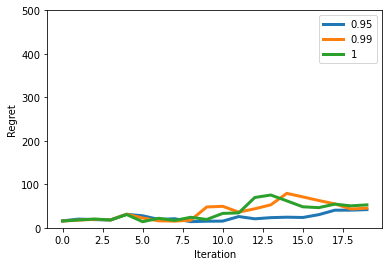

In [5]:
plot_return(rewardlist)